Build a regression model.

In [46]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**General notes:**
- This will be a linear regression, where n_pois and latitude could predict the bike_station availability
- **No Multicollinearity** It is essential that the independent variables are not too highly correlated with each other, a condition known as multicollinearity.
- Because of the above, I **will not use n_bar_restaurant, n_cafe, n_park or n_live in the model with n_pois** as the four categories are obviously subsets of the n_pois column, they will interfere with the model. I will also only take bike availability, and remove free_bikes and empty_slots as the former is calculated by the latter.

In [8]:
# load the data
data = pd.read_csv("../data/bike_stations_w_venues.csv")

In [12]:
data.head(10)

,id,name,latitude,longitude,free_bikes,empty_slots,bike_availability,ll,n_pois,n_bar_restaurant,n_cafe,n_live,n_park
0,fb337bbed72e2be090071e199899b2be,Queen St E / Woodward Ave,43.665269,-79.319796,18,1,94.74,"43.665269,-79.319796",42,24,4,3,9
1,4ff88d5880e71aa40d34cfe5d09b0ca7,Primrose Ave / Davenport Rd,43.671420,-79.445947,1,14,6.67,"43.67142,-79.445947",49,36,3,1,8
2,a09c67c0b419654d907c9134b108e328,Queen St E / Rhodes Ave,43.666224,-79.317693,12,11,52.17,"43.666224,-79.317693",50,29,6,3,10
3,d6a9daee68070a8b106cfb598d81308c,Bond St / Queen St E,43.653236,-79.376716,5,32,13.51,"43.653236,-79.376716",50,32,6,5,5
4,8f8af40d9388c8a3962559e8681d3db7,Church St / Alexander St,43.663722,-79.380288,3,32,8.57,"43.663722,-79.380288",50,34,9,2,4
5,5a441560e262305d1934fb3ada5a9517,University Ave / Gerrard St W (East Side),43.657763,-79.389165,7,18,28.00,"43.657763,-79.389165",50,37,7,1,5
6,18ea490ab3ca4d10e2927308416edbef,Edward St / Yonge St,43.656729,-79.382736,0,21,0.00,"43.656729,-79.382736",50,33,7,5,5
7,b7850948607474362d3728f19a77fdff,Euclid Ave / Bloor St W,43.664467,-79.414783,6,8,42.86,"43.664467,-79.414783",44,26,8,1,8
8,7ffd06e0207f80fe1ff6b5ae0bb0544c,Yonge St / Aylmer Ave,43.675492,-79.388858,21,2,91.30,"43.675492,-79.388858",50,37,9,0,4
9,17fadbdc5848036c8485099bbf517294,Davenport Rd / Avenue Rd,43.674991,-79.396273,0,10,0.00,"43.674991,-79.396273",50,37,5,1,7


In [104]:
# Check for NaNs in the bike_availability column - this will disrupt our p-value calculations
print(data['bike_availability'].isna().sum())

# Check for infinite values in the bike_availability column - this will disrupt our p-value calculations later
print(np.isinf(data['bike_availability']).sum())


1
0


In [106]:
# to handle the above, I will fill the one NaN in with the mean bike availability value:

data['bike_availability'].fillna(data['bike_availability'].mean(), inplace=True)

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_26063/1174640101.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bike_availability'].fillna(data['bike_availability'].mean(), inplace=True)


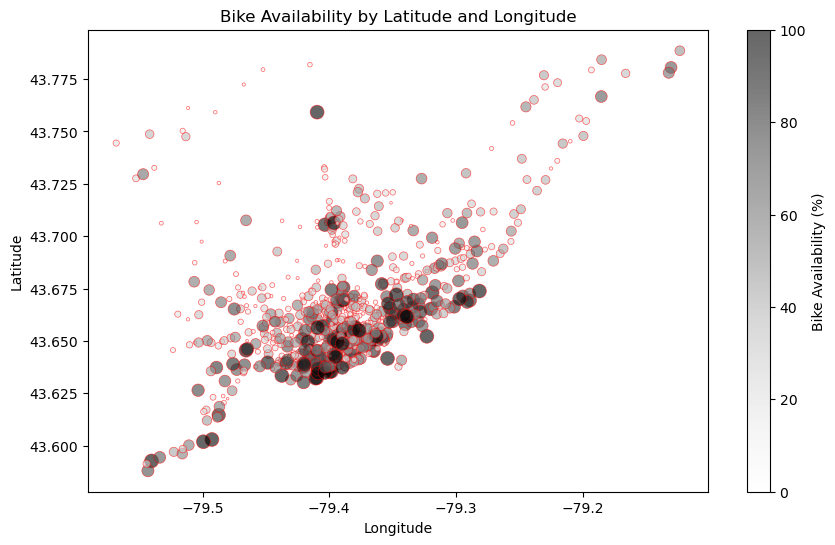

In [108]:
# correlation between lat/long and bike availability

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['longitude'], data['latitude'], 
                      s=data['bike_availability']*1,  # Adjust size factor as needed with * n
                      c=data['bike_availability'], 
                      cmap='Greys', 
                      alpha=0.6, edgecolors='red', linewidth=0.5)

plt.colorbar(scatter, label='Bike Availability (%)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike Availability by Latitude and Longitude')
plt.show()

Above: there is a noticeably clearer concentration of high bike availability in the downtown area, and more empty spots outside the city centre. This latitude and bike_availability should be explored with a model

In [110]:
# taking only numeric columns

numeric_data = data.select_dtypes(include=[float, int])
numeric_data.head(10)

,latitude,longitude,free_bikes,empty_slots,bike_availability,n_pois,n_bar_restaurant,n_cafe,n_live,n_park
0,43.665269,-79.319796,18,1,94.74,42,24,4,3,9
1,43.671420,-79.445947,1,14,6.67,49,36,3,1,8
2,43.666224,-79.317693,12,11,52.17,50,29,6,3,10
3,43.653236,-79.376716,5,32,13.51,50,32,6,5,5
4,43.663722,-79.380288,3,32,8.57,50,34,9,2,4
5,43.657763,-79.389165,7,18,28.00,50,37,7,1,5
6,43.656729,-79.382736,0,21,0.00,50,33,7,5,5
7,43.664467,-79.414783,6,8,42.86,44,26,8,1,8
8,43.675492,-79.388858,21,2,91.30,50,37,9,0,4
9,43.674991,-79.396273,0,10,0.00,50,37,5,1,7


In [112]:
# strip out the collinearity columns (empty_slots, free_bikes, n_bar_restaurant, n_cafe, n_live and n_park

numeric_data_model = numeric_data[['latitude','longitude','bike_availability','n_pois']]

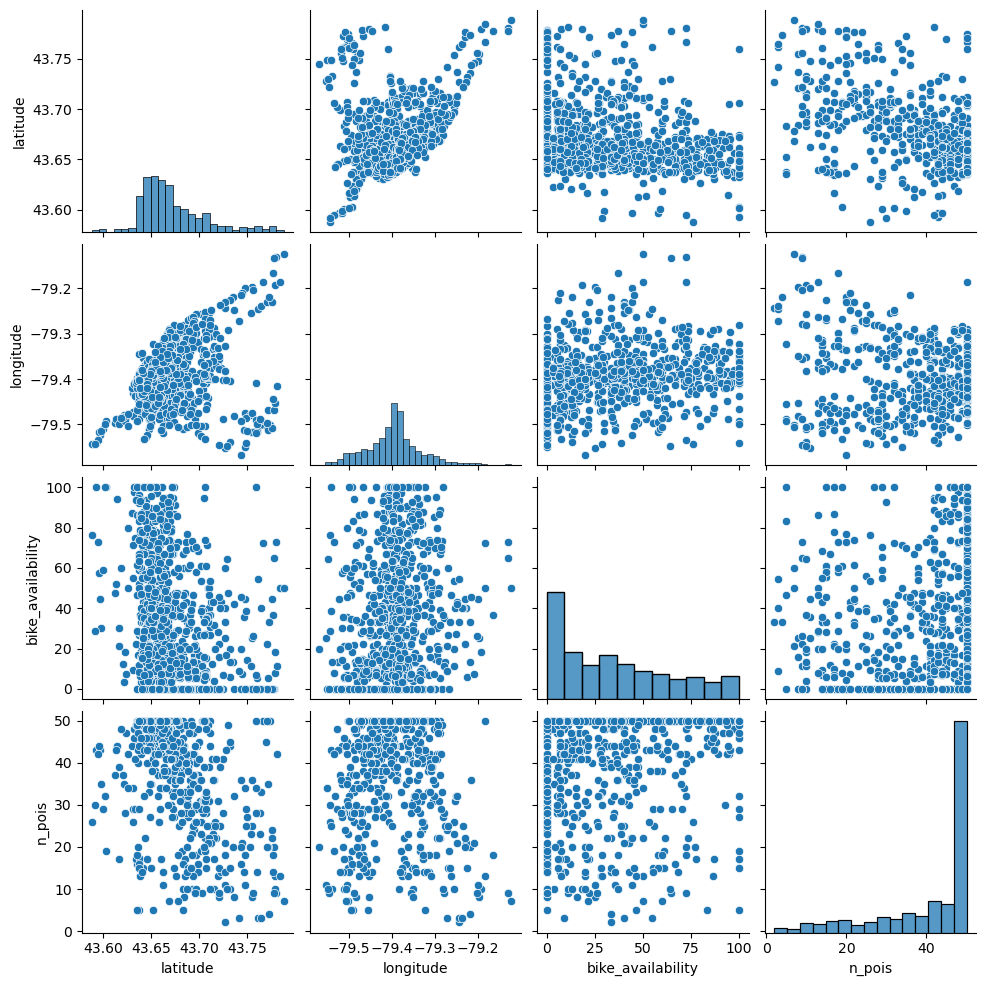

In [114]:
# seaborn's pairplot
sns.pairplot(data=numeric_data_model)

plt.show()

The most significant relationships here are:
- Bike_availability and n_pois (one up from the bottom right)
- latitude and bike_availability (one left from the top right)

Are these relationships significant? Pearson correlation coefficient test

## Provide model output and an interpretation of the results. ##

In [117]:
numeric_data_model.corr(numeric_only=True)

,latitude,longitude,bike_availability,n_pois
latitude,1.000000,0.269059,-0.311382,-0.515770
longitude,0.269059,1.000000,0.174574,-0.048242
bike_availability,-0.311382,0.174574,1.000000,0.168602
n_pois,-0.515770,-0.048242,0.168602,1.000000


Two correlations of note:
- We have a **-0.52 correlation coefficient between n_pois and latitude.**
- It is almost zero for longitude (this means there's no relationship between Points of Interest west or east of the city)
- **bike_availability and latitude at -0.31** mild negative correlation, so bikes are more plentiful the further south you go (latitude is decreasing)
- **n_pois and bike_availability +0.167** - very weak but we will test it with p-value

In [125]:
stat, p1 = stats.pearsonr(numeric_data_model['latitude'], numeric_data_model['n_pois'])
stat, p2 = stats.pearsonr(numeric_data_model['latitude'], numeric_data_model['bike_availability'])
stat, p3 = stats.pearsonr(numeric_data_model['n_pois'], numeric_data_model['bike_availability'])


print(f'Latitude vs Number of Places of Interest: p-value = {p1}')
print(f'Latitude vs Bike Availability (%): p-value = {p2}')
print(f'Number of Places of Interest vs Bike Availability (%): p-value = {p3}')

Latitude vs Number of Places of Interest: p-value = 2.4675158445612873e-57
Latitude vs Bike Availability (%): p-value = 4.980885703440573e-20
Number of Places of Interest vs Bike Availability (%): p-value = 1.0977883023673506e-06


p-value of 2.47*10^-57

p-value of 5*10^-20

p-value of 1.1*10^-6

Although the relationships are small to moderate correlations, these are clearly meaningful p-values that could not be reproduced by chance. We can conclude:
- There is a **statistically significant relationship** between *latitude* in Toronto and the *number of Bikes availabile* at bike stations.
- There is also a **similarly significant relationship** between *latitude* and the *number of Points of Interest* as called by Foursquare.
- There is a **statistically significant relationship** between the *number of Points of Interest* and the *number of bikes available* at bike stations. 

In [171]:
# simple linear regression for bike availability vs latitude
y = numeric_data_model['bike_availability'] # bike availability is the dependent variable
X = numeric_data_model['latitude'] # latitude is the independent variable
X = sm.add_constant(X)
X.head()

,const,latitude
0,1.0,43.665269
1,1.0,43.671420
2,1.0,43.666224
3,1.0,43.653236
4,1.0,43.663722


In [173]:
model = sm.OLS(y,X) # Ordinary Least Squares method
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      bike_availability   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     88.47
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           4.98e-20
Time:                        17:31:55   Log-Likelihood:                -3928.8
No. Observations:                 826   AIC:                             7862.
Df Residuals:                     824   BIC:                             7871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.196e+04   1267.362      9.434      0.0

In [135]:
# simple linear regression for number of POIs vs latitude
y = numeric_data_model['n_pois'] # number of points of interest is the dependent variable
X = numeric_data_model['latitude'] # latitude is the independent variable
X = sm.add_constant(X)
X.head()

,const,latitude
0,1.0,43.665269
1,1.0,43.671420
2,1.0,43.666224
3,1.0,43.653236
4,1.0,43.663722


In [137]:
model = sm.OLS(y,X) # Ordinary Least Squares method
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 n_pois   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     298.6
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           2.47e-57
Time:                        14:15:33   Log-Likelihood:                -3138.2
No. Observations:                 826   AIC:                             6280.
Df Residuals:                     824   BIC:                             6290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8451.0274    486.671     17.365      0.0

Notes:
- R^2 of only 0.266 which means that the model of latitude ALONE only explains 26% of the variance in bike availability.
- This was the strongest correlation in the Pearson test (-0.51)

**Multivariate Linear Regression: Can we predict bike availability by Latitude AND the number of POIs nearby?**

In [178]:
y = numeric_data_model['bike_availability'] # bike availability is the dependent variable
X = numeric_data_model[['n_pois', 'latitude']] # latitude and n_pois are independent variables
X = sm.add_constant(X)
X.head()

,const,n_pois,latitude
0,1.0,42,43.665269
1,1.0,49,43.671420
2,1.0,50,43.666224
3,1.0,50,43.653236
4,1.0,50,43.663722


In [180]:
model = sm.OLS(y, X) # ordinary least squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      bike_availability   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     44.23
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           5.71e-19
Time:                        17:43:30   Log-Likelihood:                -3928.8
No. Observations:                 826   AIC:                             7864.
Df Residuals:                     823   BIC:                             7878.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.174e+04   1482.043      7.921      0.0

The model is even weaker predicting bike availability, it accounts for only 9.7% of the variance in bike availability.

Concluding thoughts:
- Avoiding multicollinearity in this is very difficult because the number of certain category POIs such as number of live venues or parks, which may explain bike availability, is directly contributing to the number of total POIs, as number of bikes free or empty slots free contributes to the bike availability.
  
- The number of POIs data could be significantly improved if the limit on venues returned was higher. I made the deliberate call for a radius of 800m for locations around the bike stations because any higher would lead to virtually all of the  downtown stations being at 50 POIs, with very little insight into which 50 made my call and which were left out, and very little analytical value could be drawn from it.

# Stretch

How can you turn the regression model into a classification model?